In [ ]:
import pandas as pd
import numpy as np
emails = pd.read_csv('emails.csv',header=None)
df = pd.DataFrame(emails)

#только имена папок
df[0] = df[0].apply(lambda x: x.split('/')[1])

In [ ]:
#число писем

print ('Number of emails: '+str(df.shape[0]))

Number of emails: 12275


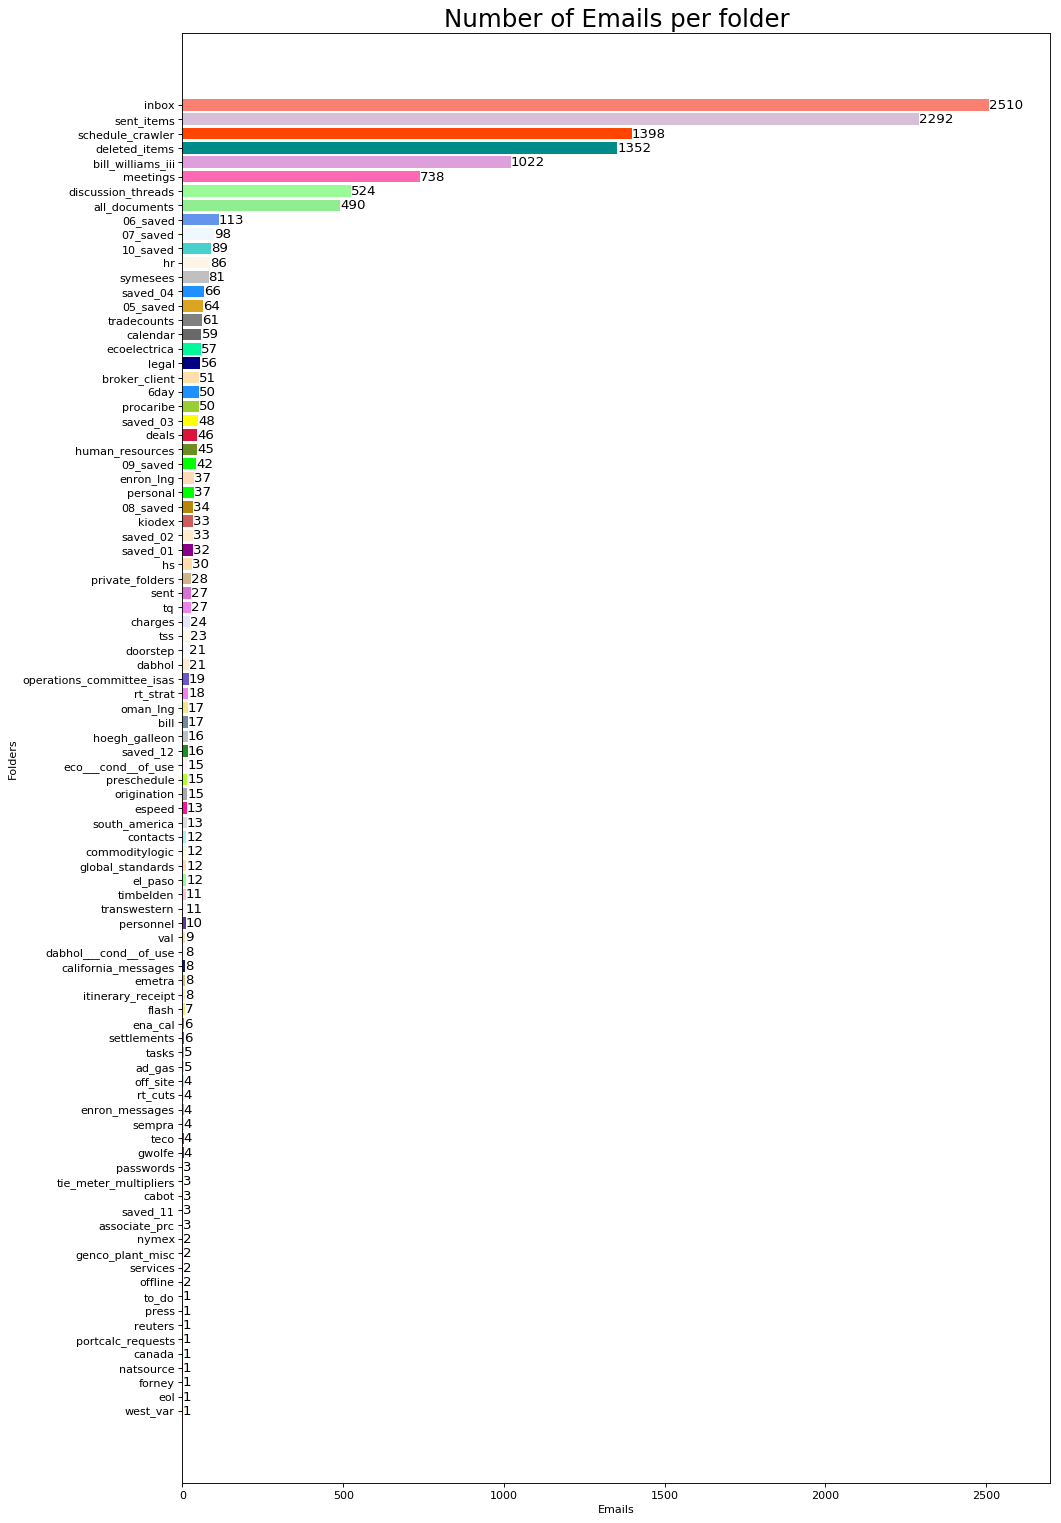

In [ ]:
#визуализация сколько писем в папке

import random
from matplotlib import pyplot as plt


#подготовка данных
df_plot = df.groupby(0).size().reset_index(name='counts')
df_plot = df_plot.sort_values('counts')
n = df_plot[0].unique().__len__()+1
all_colors = list(plt.cm.colors.cnames.keys())
random.seed(90)
c = random.choices(all_colors, k=n)

#гистограмма
plt.figure(figsize=(14,24), dpi= 80)
plt.barh(df_plot[0],df_plot['counts'], color=c)
for i, val in enumerate(df_plot['counts'].values):
    plt.text( val,i, int(val), horizontalalignment='left', verticalalignment='center', fontdict={'fontweight':500, 'size':12})


#оформление
plt.title("Number of Emails per folder", fontsize=22)
plt.xlabel('Emails')
plt.ylabel('Folders')
plt.xlim(0, 2700)
plt.show()



In [ ]:
#оставить папки где больше 30 писем

df['counts'] = df.groupby(0)[0].transform('size')
df = df[df['counts']>=30]

df[0] = pd.Categorical(df[0])
df['class'] = df[0].cat.codes

#число оставшихся писем

print ('Number of emails: '+str(df.shape[0]))

Number of emails: 11724


In [ ]:
# training (90%) test(10%) :

emails = list(df[1])
labels = list(df['class'])

unique_labels = list(df['class'].unique())

x_train = []
x_test =[]
y_test = []
y_train = []

for label in unique_labels:
    temp = [] # временный список для всех писем с одинаковыми лейблами

    for k in range(len(labels)):

        if labels[k] == label:
            temp.append(emails[k])

    split = int(len(temp)*0.9)

    x_train.extend(temp[:split])
    x_test.extend(temp[split:])

    y_train.extend([label]*len(temp[:split]))
    y_test.extend([label]*len(temp[split:]))


# число писем training data set:
print ('Number of emails in the training data set: '+str(len(y_train)))
# число писем test data set:
print ('Number of emails in the test data set: '+str(len(y_test)))

Number of emails in the training data set: 10537
Number of emails in the test data set: 1187


In [ ]:
import string
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.stem import PorterStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
def preprocessing(text):
    """NLP preprocessing data techniques"""

    text2 = " ".join("".join([" " if ch in string.punctuation else ch for ch in text]).split())

    tokens = [word for sent in nltk.sent_tokenize(text2) for word in nltk.word_tokenize(sent)]

    tokens = [word.lower() for word in tokens]

    stopwds = stopwords.words('english')
    tokens = [token for token in tokens if token not in stopwds]

    tokens = [word for word in tokens if len(word)>=3]

    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    tagged_corpus = pos_tag(tokens)
    Noun_tags = ['NN','NNP','NNPS','NNS']
    Verb_tags = ['VB','VBD','VBG','VBN','VBP','VBZ']
    lemmatizer = WordNetLemmatizer()

    def prat_lemmatize(token,tag):
      if tag in Noun_tags:
        return lemmatizer.lemmatize(token,'n')
      elif tag in Verb_tags:
        return lemmatizer.lemmatize(token,'v')
      else:
        return lemmatizer.lemmatize(token,'n')

    pre_proc_text =   " ".join([prat_lemmatize(token,tag) for token,tag in tagged_corpus])
    return pre_proc_text


In [ ]:
# применение предварительной обработки к тестовым данным

x_train_preprocessed = []
for i in x_train:
  x_train_preprocessed.append(preprocessing(i))

x_test_preprocessed = []
for i in x_test:
  x_test_preprocessed.append(preprocessing(i))

In [ ]:
#TFIDF vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

max_features = 4000

vectorizer = TfidfVectorizer(min_df=2,max_df=0.7, ngram_range=(1, 2), stop_words='english', max_features= max_features,strip_accents='unicode', norm='l2')
x_train_2 = vectorizer.fit_transform(x_train).todense()
x_test_2 = vectorizer.transform(x_test).todense()

In [ ]:
#Deep Learning

from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.layers import Activation, Conv1D, Dropout, Dense, Embedding, Flatten, Input, MaxPooling1D, BatchNormalization
from keras.metrics import categorical_accuracy


Using TensorFlow backend.


In [ ]:
#гиперпараметры

np.random.seed(1337)
nb_classes = 33
batch_size = 16
nb_epochs = 10

In [ ]:
#кодирока вектора

Y_train = np_utils.to_categorical(y_train, nb_classes)

In [ ]:
# доп параметры

x = np.array(x_train_2)
x_train_conv = x.reshape(len(y_train), max_features, 1)

x = np.array(x_test_2)
x_test_conv = x.reshape(len(y_test), max_features, 1)

In [ ]:
# архитектура модели

model = Sequential()
model.add(Conv1D(128, 3, activation='relu', input_shape=(max_features,1)))
model.add(MaxPooling1D(3))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(33, activation='softmax'))

my_optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=my_optimizer,metrics=['accuracy'])
print (model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 3998, 128)         512       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1332, 128)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1330, 128)         49280     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 443, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 441, 128)          49280     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 147, 128)          0         
_________________________________________________________________
flat

In [ ]:
# деление на training и validation data:

from sklearn.model_selection import train_test_split

XTraining, XValidation, YTraining, YValidation = train_test_split(x_train_conv,Y_train,stratify=Y_train,test_size=0.1) # before model building

In [ ]:
# checkpoint
filepath="my_model.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True)

# тренировка модели

model_history = model.fit(XTraining,YTraining,validation_data = (XValidation,YValidation), batch_size=batch_size, epochs=nb_epochs,callbacks=[checkpoint])

Instructions for updating:
Use tf.cast instead.
Train on 9483 samples, validate on 1054 samples
Epoch 1/10
9483/9483 [==============================] - 16s 2ms/step - loss: 0.7563 - acc: 0.7794 - val_loss: 0.2622 - val_acc: 0.9213

Epoch 00001: val_acc improved from -inf to 0.92125, saving model to my_model.hdf5
Epoch 2/10
9483/9483 [==============================] - 11s 1ms/step - loss: 0.1743 - acc: 0.9459 - val_loss: 0.1379 - val_acc: 0.9573

Epoch 00002: val_acc improved from 0.92125 to 0.95731, saving model to my_model.hdf5
Epoch 3/10
9483/9483 [==============================] - 11s 1ms/step - loss: 0.1017 - acc: 0.9706 - val_loss: 0.1141 - val_acc: 0.9687

Epoch 00003: val_acc improved from 0.95731 to 0.96869, saving model to my_model.hdf5
Epoch 4/10
9483/9483 [==============================] - 11s 1ms/step - loss: 0.0577 - acc: 0.9828 - val_loss: 0.1064 - val_acc: 0.9725

Epoch 00004: val_acc improved from 0.96869 to 0.97249, saving model to my_model.hdf5
Epoch 5/10
9483/9483 [=

In [ ]:
from keras.models import load_model

model = load_model(filepath)

YT = np.argmax(YTraining, axis = 1)
YV = np.argmax(YValidation, axis = 1)


y_train_predclass = model.predict_classes(XTraining,batch_size=batch_size)
y_validation_predclass = model.predict_classes(XValidation,batch_size=batch_size)
y_test_predclass = model.predict_classes(x_test_conv,batch_size=batch_size)

from sklearn.metrics import accuracy_score,classification_report

print ("Deep Neural Network - Train accuracy: "+str(accuracy_score(YT, y_train_predclass)))
print ("Deep Neural Network - Validation accuracy: "+str(accuracy_score(YV,y_validation_predclass)))
print ("Deep Neural Network - Test accuracy: "+str(accuracy_score(y_test,y_test_predclass)))
print ("Deep Neural Network - Train Classification Report")
print (classification_report(YT,y_train_predclass))
print ("Deep Neural Network - Validation Classification Report")
print (classification_report(YV,y_validation_predclass))
print ("Deep Neural Network - Test Classification Report")
print (classification_report(y_test,y_test_predclass))


Deep Neural Network - Train accuracy: 0.9950437625224086
Deep Neural Network - Validation accuracy: 0.9810246679316889
Deep Neural Network - Test accuracy: 0.9587194608256108
Deep Neural Network - Train Classification Report
              precision    recall  f1-score   support

           0       1.00      0.86      0.93        51
           1       0.99      0.95      0.97        91
           2       0.97      0.99      0.98        79
           3       1.00      1.00      1.00        27
           4       1.00      1.00      1.00        33
           5       0.99      1.00      0.99        72
           6       1.00      1.00      1.00        40
           7       1.00      0.99      0.99       397
           8       1.00      1.00      1.00       827
           9       1.00      1.00      1.00        41
          10       0.98      1.00      0.99        48
          11       1.00      0.97      0.99        37
          12       0.99      1.00      1.00      1094
          13      